<a href="https://colab.research.google.com/github/dmaxim/ufl-ai/blob/main/nonlinear_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# introduction to model over-fitting

You can find a supplemental video about this exercise [here](https://youtu.be/ogesATk-Jpw)

Once you know how to systematically increase the depth and width of your neural network, you can very easily build *very* large networks with only a few lines of actual code.

For example, the next code cell creates a neural network with over 33 *million* trainable parameters, in just a few seconds!

In [1]:
import tensorflow as tf

nw_width = 512
nw_hdpth = 128

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=nw_width, activation=tf.keras.activations.relu, input_shape=[1]))
for i in range(nw_hdpth):
  model.add(tf.keras.layers.Dense(units=nw_width, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1024      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 512)               2

Given that it is *so* easy to build *very large* neural networks, you might be wondering why we don't just analyze *all data* with *very large* neural networks!

Well, if you look at the neural-network literature, it may seem like we actually *do* analyze *all* data with *very large* neural networks. The 'size' (measured in number of trainable parameters) of state-of-the-art neural networks has been increasing *dramatically* over recent years, and it seems that - in many complex problem domains - larger networks often result in *better* inferences.

There are some *technical* problems with naive implementations of *very deep* nerual networks - like the [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem - but these problems have largely been solved by 'fancy' network architectures like [residual networks](https://en.wikipedia.org/wiki/Residual_neural_network).

Of course, large networks must perform a *large number* of calculations, and calculations take time. Fortunately, the 'forward pass' through a neural network is *very fast*, even for large networks. Backpropagation during training can take a bit longer, but hardware acceleration using GPUs or other 'specialized' hardware has essentially solved this problem. I could probably train a 50-million-parameter network on my laptop (which has an NVIDIA GPU) in a few days, and a big computer with multiple GPUs could probably train it in under 5 minutes!

Big networks also consume more memory, which could limit their use on 'small' devices like 'phones' and appliances (did you know both apple and android phones have dedicated hardware devoted to running neural networks?). However, cloud-based computing allows you to make predictions 'online', using any hardware available on the cloud; only the data and results need to be sent over the network.

Simple optimization routines like stochastic gradient descent *can* get 'stuck' when used to train large networks, failing to find a good approximation of the loss function's *global optimum*. But there are *lots* of 'fancier' optimization methods that don't suffer as much from these problems.

So, from a *computational* perspective, there doesn't seem to be any *strong* argument in favor of using *simpler* neural networks, at least not in general.

## a 'statistical' argument against very large neural networks

Given enough time and computational resources, we could probably fit *any* arbitrarily complex neural network to *any* data set. But is it a 'good idea' to build 'arbitrarily complex' statistical models?

Later on in the course, we'll spend a lot of time looking at "overfitting" with complex neural networks.

In this notebook, I'd like to go through a short exercise that might get you thinking about some of the problems that could arise when the model becomes 'too complex' for the data.

It will also give you a chance to practice building nonlinear neural networks!

## back to 'linear' data

To illustrate "overfitting", let's go back to considering some *simple* data simulated according to a linear model.

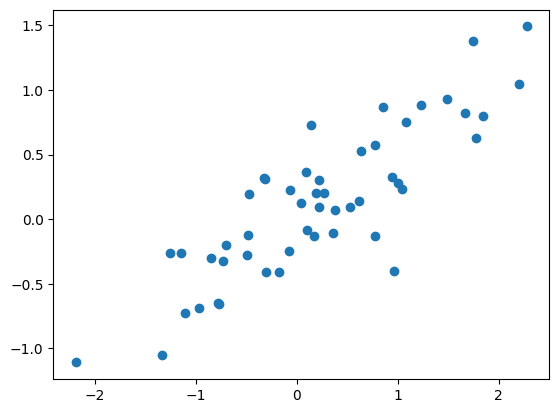

In [2]:
import sklearn.datasets
import matplotlib.pyplot as plt

x,y = sklearn.datasets.make_regression(n_samples=50,
                                       n_features=1,
                                       bias=0.0,
                                       noise=30.0,
                                       random_state=602951)
y = y / 100.0

plt.scatter(x,y, marker='o')

This should look pretty familiar by now. We just simulated 50 1-dimensional data points along a diagonal line. We scaled the y-values, so they fall roughly between -1.5 and +1.5, but that's just for convenience.

Of course, we can fit a simple linear model to these data, and check the fit. This should also look fairly familar by now.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_130 (Dense)           (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0926
Epoch 2/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0920
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0916
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0912
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0909
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0906
Epoch 7/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0904
Epoch 8/100
5/5 [=========================

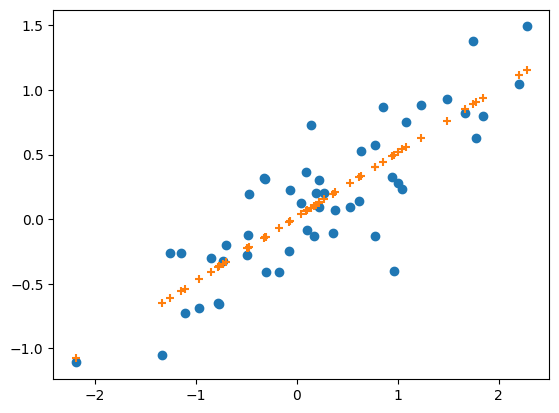

In [3]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=[1]))
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

data = tf.data.Dataset.from_tensor_slices((x,y)).batch(10)
model.fit(data, epochs=100)

y_hat = model.predict(x)

plt.scatter(x,y, marker='o')
plt.scatter(x,y_hat, marker='+')

We get a pretty nice, expected linear fit (orange +) through the center of the simulated data (blue dots).

Incidentally, if you'd like to see the 'best fit' values for the slope and bias of your liner model, you can:

In [4]:
print(model.trainable_variables)

[<tf.Variable 'dense_130/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.49912837]], dtype=float32)>, <tf.Variable 'dense_130/bias:0' shape=(1,) dtype=float32, numpy=array([0.01873101], dtype=float32)>]


This will print the 'raw' tensorflow Variables associated with your neural network. For this 'small' network, there are only 2 trainable variables:

* the slope - called the "kernel" of the Dense neuron
* the y-intercept - called the "bias" of the neuron

If you look at the printed output, you should see a part that reads

    'dense_XXX/kernel:0'

where "XXX" is an auto-generated number that tensorflow assigns to 'name' the dense layer of your network. After that, you see the specification of the "kernel" (ie, slope) variable:

    shape=(1, 1) dtype=float32, numpy=array([[0.49990593]], dtype=float32)

In my case, the *value* of the best-fit slope was 0.49990593; this is pretty close to 0.5.

Similarly, we can find the 'best fit' value for the bias variable by looking for

    'dense_XXX/bias:0'

and reading its value:

    shape=(1,) dtype=float32, numpy=array([0.01880047], dtype=float32)

In my case, the 'best fit' y-intercept value was 0.01880047; this is pretty close to 0.0.

The

    print(model.trainable_variables)

statement will print the current values of *all* the trainable parameters in your model. For simple models like this one, we can manually read through the output and interpret the 'meaning' of the values, but for very large networks, printing all the Variables to the screen is unlikely to be very helpful!

## fitting a nonlinear model to linear data

Okay, but we've fit linear models, before. Let's fit a *nonlinear* model to these data, and see how 'good' it is.

The following code cell is an end-to-end example, including data simulation, model fitting and plotting the model fit.

The only thing missing is the model!

In this case, we simulate a small sample of data from a linear model, and we fit a linear model to the data, for comparison.

Your job is to build a *nonlinear* neural network model, which should be implemented between the

    ## -- BEG BUILD MODEL

and

    ## -- END BUILD MODEL

comments in the code cell. Replace the "FIXME" text with your model implementation. Notice that an "empty" Sequential model has already been created; you just need to add layers to the empty model, to build your nonlinear neural network.

Before you take the quiz, you should *not* change *anything* in the code cell, except for your model implementation. *After* you've completed the quiz, feel free to play around with different model implementations, if you'd like. And remember that you can always grab a 'fresh' version of this notebook from the course link, if you need to.

Build your nonlinear model according to the following specification:

* Your model should have 4 hidden layers (ie, the network's total depth should be 6).
* Use Dense layers for *all* layers in your network.
* Use ReLU activations on *all* layers of your network *except* the output layer, which should have *linear* activation.
* The width of *all* layers in your model *except* the output layer should be 64.

That's it. Please implement your model and run the code cell to confirm it works and check your model's fit.

2/2 [==============================] - 0s 5ms/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 64)                128       
                                                                 
 dense_141 (Dense)           (None, 64)                4160      
                                                                 
 dense_142 (Dense)           (None, 64)                4160      
                                                                 
 dense_143 (Dense)           (None, 64)                4160      
                                                                 
 dense_144 (Dense)           (None, 64)                4160      
                                                                 
 dense_145 (Dense)           (None, 1)                 65        
                                                                 
Tot

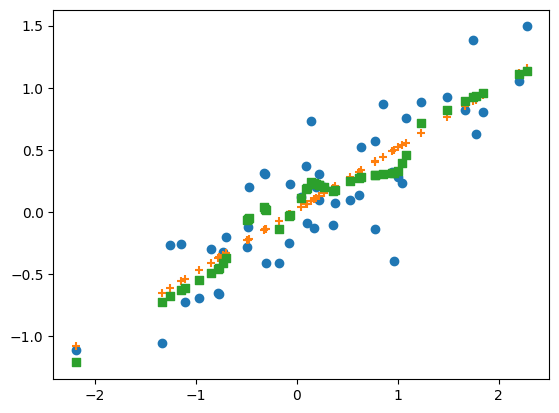

In [8]:
import sklearn.datasets
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate linear data
x,y = sklearn.datasets.make_regression(n_samples=50,
                                       n_features=1,
                                       bias=0.0,
                                       noise=30.0,
                                       random_state=602951)
y = y / 100.0
data = tf.data.Dataset.from_tensor_slices((x,y)).batch(10)

# fit linear model, so we can compare later
lm = tf.keras.Sequential()
lm.add(tf.keras.layers.Dense(units=1, input_shape=[1]))
lm.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
lm.fit(data, epochs=100, verbose=0)
lm_yhat = lm.predict(x)

# build and fit nonlinear model
model = tf.keras.Sequential()
## -- BEG BUILD MODEL
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, input_shape=[1]))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

## -- END BUILD MODEL
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

model.fit(data, epochs=500)

y_hat = model.predict(x)

# plot results
plt.scatter(x,y, marker='o')
plt.scatter(x,lm_yhat, marker='+')
plt.scatter(x,y_hat, marker='s')

In the plot, the blue circles indicate the 'true' simulated data. The orange + indicates the best-fit *linear* model, and the green squares indicate the fit to the training data for your *nonlinear* neural network.

Do you think the nonlinear model is a 'better' fit?